In [0]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.optimizers import SGD
import os
import cv2
from PIL import Image
from PIL.Image import FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM
import numpy as np

In [2]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2020-05-12 01:55:41--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  22.6MB/s    in 12s     

2020-05-12 01:55:53 (28.0 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [3]:
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_1

In [4]:
!ls

cell_images  cell_images.zip  sample_data


In [0]:
infected = os.listdir('./cell_images/Parasitized')
uninfected = os.listdir('./cell_images/Uninfected')

In [6]:
data = []
labels = []
new_data = []
new_labels = []
for i in infected:
  try:
    image = cv2.imread('./cell_images/Parasitized/' + i)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((50, 50))
    data.append(np.array(image))
    labels.append(1)

    # for part 2:
    rotate1 = image.rotate(45)
    rotate2 = image.rotate(75)
    blur = cv2.blur(np.array(image), (10, 10))
    flip1 = image.transpose(method = FLIP_TOP_BOTTOM)
    flip2 = image.transpose(method = FLIP_LEFT_RIGHT)
    new_data.append(np.array(image))
    new_labels.append(1)
    new_data.append(np.array(rotate1))
    new_labels.append(1)
    new_data.append(np.array(rotate2))
    new_labels.append(1)
    new_data.append(np.array(blur))
    new_labels.append(1)
    new_data.append(np.array(flip1))
    new_labels.append(1)
    new_data.append(np.array(flip2))
    new_labels.append(1)

  except AttributeError:
    print('')

for i in uninfected:
  try:
    image = cv2.imread('./cell_images/Uninfected/' + i)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((50, 50))
    data.append(np.array(image))
    labels.append(0)
    
    # for part 2:
    rotate1 = image.rotate(45)
    rotate2 = image.rotate(75)
    blur = cv2.blur(np.array(image), (10, 10))
    flip1 = image.transpose(method = FLIP_TOP_BOTTOM)
    flip2 = image.transpose(method = FLIP_LEFT_RIGHT)
    new_data.append(np.array(image))
    new_labels.append(0)
    new_data.append(np.array(rotate1))
    new_labels.append(0)
    new_data.append(np.array(rotate2))
    new_labels.append(0)
    new_data.append(np.array(blur))
    new_labels.append(0)
    new_data.append(np.array(flip1))
    new_labels.append(0)
    new_data.append(np.array(flip2))
    new_labels.append(0)
  except AttributeError:
    print('')

In [7]:
X = np.array(data)
y = np.array(labels)
X.shape, y.shape

((27558, 50, 50, 3), (27558,))

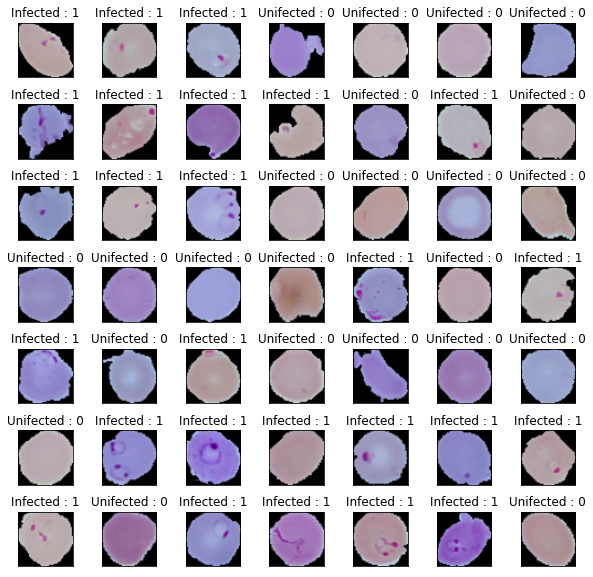

In [8]:
plt.figure(1 , figsize = (10 , 10))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , X.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X[r[0]])
    plt.title('{} : {}'.format('Infected' if y[r[0]] == 1 else 'Unifected' ,
                               y[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()


In [0]:
# PREP, SCALE IMAGES
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255

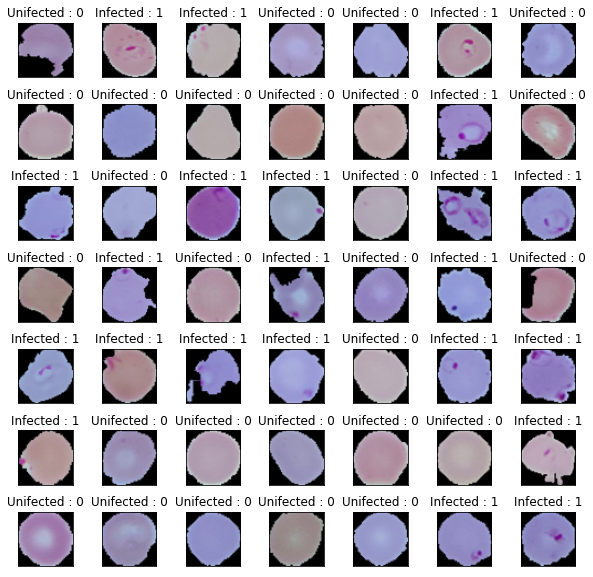

In [10]:
plt.figure(1 , figsize = (10 , 10))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , X.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X[r[0]])
    plt.title('{} : {}'.format('Infected' if y[r[0]] == 1 else 'Unifected' ,
                               y[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [0]:
# SPLIT INTO TRAIN, VALIDATION, AND TEST SETS
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state = 111)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = 111)

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((15501, 50, 50, 3),
 (5167, 50, 50, 3),
 (15501,),
 (5167,),
 (6890, 50, 50, 3),
 (6890,))

**PART 1:** First Model

In [0]:
def prelim():
  inp = Input((50, 50, 3))
  
  out = Conv2D(32, kernel_size = (7,7), padding = 'same', activation = 'relu')(inp)
  out = BatchNormalization()(out)
  out = Conv2D(filters = 90, kernel_size = (3,3), padding = 'valid', activation = 'relu')(out)
  out = BatchNormalization()(out)
  out = Conv2D(filters = 10, kernel_size = (5,5), padding = 'same', activation = 'relu')(out)
  
  out = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(out)
  out = Flatten()(out)

  out = Dense(512, activation = 'relu')(out)
  out = Dropout(rate = 0.3)(out)
  out = Dense(512, activation = 'relu')(out)
  out = Dropout(rate = 0.3)(out)

  out = Dense(1, activation = 'sigmoid')(out)

  model = tf.keras.Model(inputs=inp, outputs=out)
  model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  return model

In [0]:
def train_model(model, X_train, y_train, X_val, y_val):
  model = model
  rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=2, min_lr=0.000001)
  callbacks = [rlr]
  history = model.fit(x=X_train, y=y_train,
                        batch_size=64,
                        epochs=25,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=1)
  return history

In [16]:
history = train_model(prelim(), X_train, y_train, X_val, y_val)

Epoch 1/25
243/243 [==============================] - 12s 51ms/step - loss: 0.6826 - accuracy: 0.6530 - val_loss: 0.9914 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 2/25
243/243 [==============================] - 12s 49ms/step - loss: 0.2491 - accuracy: 0.9076 - val_loss: 0.2638 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 3/25
243/243 [==============================] - 12s 49ms/step - loss: 0.1627 - accuracy: 0.9466 - val_loss: 0.1515 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 4/25
243/243 [==============================] - 12s 49ms/step - loss: 0.1455 - accuracy: 0.9517 - val_loss: 0.2562 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 5/25
243/243 [==============================] - 12s 49ms/step - loss: 0.1234 - accuracy: 0.9588 - val_loss: 0.7342 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 6/25
243/243 [==============================] - 12s 50ms/step - loss: 0.0964 - accuracy: 0.9656 - val_loss: 0.1331 - val_accuracy: 0.9545 - lr: 5.0000e-04
Epoch 7/25
243/243 [==============================] - 

In [0]:
def summarize_diagnostics(history, title):
  plt.title('Classification Accuracy: ' + title)
  plt.plot(history.history['accuracy'], color='navy', label='train')
  plt.plot(history.history['val_accuracy'], color='firebrick', label='test')
  plt.grid(True)
  plt.xlabel('Ephochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show()

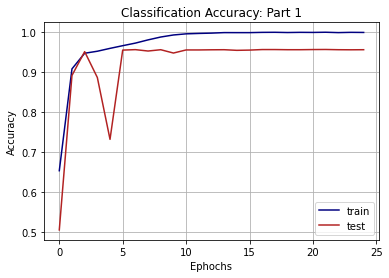

In [18]:
summarize_diagnostics(history, 'Part 1')

**PART 2:** Data Augmentation

In [0]:
# Using augmented image lists generated earlier
X_new = np.array(new_data)
y_new = np.array(new_labels)
X_new.shape, y_new.shape
X_new = X_new.astype(np.float32)
y_new = y_new.astype(np.int32)
X_new = X_new/255

In [0]:
# SPLIT INTO TRAIN, VALIDATION, AND TEST SETS
X_train_val_new, X_test_new, y_train_val_new, y_test_new = train_test_split(X_new, y_new, train_size = 0.3, random_state = 111)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_val_new, y_train_val_new, train_size = 0.5, random_state = 111)

In [27]:
X_train_new.shape

(24802, 50, 50, 3)

In [28]:
# Evaluate on the same model as part 1:
history_new = train_model(prelim(), X_train_new, y_train_new, X_val_new, y_val_new)

Epoch 1/25
388/388 [==============================] - 23s 60ms/step - loss: 0.6332 - accuracy: 0.6845 - val_loss: 1.3985 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 2/25
388/388 [==============================] - 23s 59ms/step - loss: 0.2542 - accuracy: 0.9050 - val_loss: 0.2941 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 3/25
388/388 [==============================] - 23s 59ms/step - loss: 0.2123 - accuracy: 0.9284 - val_loss: 1.4667 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 4/25
388/388 [==============================] - 23s 60ms/step - loss: 0.1809 - accuracy: 0.9409 - val_loss: 0.1651 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/25
388/388 [==============================] - 23s 60ms/step - loss: 0.1551 - accuracy: 0.9479 - val_loss: 0.3392 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 6/25
388/388 [==============================] - 23s 60ms/step - loss: 0.1415 - accuracy: 0.9531 - val_loss: 0.3595 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 7/25
388/388 [==============================] - 23s 

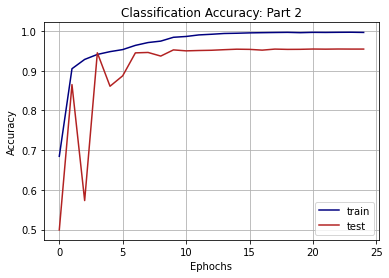

In [61]:
def summarize_diagnostics(history, title):
  plt.title('Classification Accuracy: ' + title)
  plt.plot(history.history['accuracy'], color='navy', label='train')
  plt.plot(history.history['val_accuracy'], color='firebrick', label='test')
  plt.grid(True)
  plt.xlabel('Ephochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show()
summarize_diagnostics(history_new, 'Part 2')

**Part 3:** Deeper Model

In [30]:
# Using ResNet50
resnet = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet',
                                        input_shape = (50, 50, 3))
resnet.trainable = False
for layer in resnet.layers:
  layer.trainable = False

base_rn = resnet
base_out = base_rn.output
out = tf.keras.layers.Flatten()(base_out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dropout(rate=0.3)(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dropout(rate=0.3)(out)

out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

model = tf.keras.Model(inputs=base_rn.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
# Train Model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr]
history = model.fit(x = X_train, y = y_train, 
                    batch_size=64,
                    epochs=25, 
                    validation_data=(X_val, y_val), 
                    callbacks=callbacks,
                    verbose=1)


Epoch 1/25
243/243 [==============================] - 17s 71ms/step - loss: 0.7046 - accuracy: 0.5264 - val_loss: 0.6882 - val_accuracy: 0.5183 - lr: 1.0000e-04
Epoch 2/25
243/243 [==============================] - 16s 64ms/step - loss: 0.6758 - accuracy: 0.5807 - val_loss: 0.6522 - val_accuracy: 0.6503 - lr: 1.0000e-04
Epoch 3/25
243/243 [==============================] - 16s 64ms/step - loss: 0.6602 - accuracy: 0.6053 - val_loss: 0.6957 - val_accuracy: 0.5357 - lr: 1.0000e-04
Epoch 4/25
243/243 [==============================] - 16s 64ms/step - loss: 0.6470 - accuracy: 0.6267 - val_loss: 0.6266 - val_accuracy: 0.6702 - lr: 1.0000e-04
Epoch 5/25
243/243 [==============================] - 16s 65ms/step - loss: 0.6381 - accuracy: 0.6400 - val_loss: 0.7550 - val_accuracy: 0.5614 - lr: 1.0000e-04
Epoch 6/25
243/243 [==============================] - 16s 64ms/step - loss: 0.6309 - accuracy: 0.6521 - val_loss: 0.6804 - val_accuracy: 0.5794 - lr: 1.0000e-04
Epoch 7/25
243/243 [==============

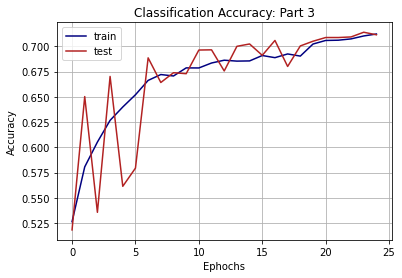

In [62]:
def summarize_diagnostics(history, title):
  plt.title('Classification Accuracy: ' + title)
  plt.plot(history.history['accuracy'], color='navy', label='train')
  plt.plot(history.history['val_accuracy'], color='firebrick', label='test')
  plt.grid(True)
  plt.xlabel('Ephochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show()
summarize_diagnostics(history, 'Part 3')